# Data analysis for data streaming project

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from datetime import timedelta

sns.set_theme()

Please note that in the future graphs representation of events in time, a bar at 10 represent a click and a bar at 1 a display.

In [ ]:
def get_one_min_subset(dataframe, minutes=1):
  df = dataframe.copy()
  df.reset_index(inplace=True)
  min_time = pd.Timestamp(df.sample()["timestamp"].values[0])
  max_time = min_time + timedelta(minutes=minutes)
  idx = df.index[(df.timestamp > min_time) & (df.timestamp < max_time)]
  df = df.loc[idx]
  return df

def plot_clicks_displays(dataframe, field, value):
  df = dataframe.copy()
  fig, ax = plt.subplots(figsize=(50,10))
  locator = mdates.MinuteLocator(interval=1)
  ax.xaxis.set_major_locator(locator)
  ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
  fig.autofmt_xdate()
  df.loc[df[field]!= value, "eventType"] = 0
  df["eventType"].plot()

## Load clicks & displays data

Data was collected on a 20 minute duration

In [ ]:
base = pd.read_json("/content/drive/MyDrive/Colab Notebooks/Dauphine IASD/Flux de données/data.json", lines=True)
base["eventType"] = base["evenType"].apply(lambda x: 10 if x == "click" else 1)
base.drop(columns="evenType",inplace=True)
base["impressionId"] = base["impressionId"].apply(lambda x: x.replace(")",""))
base = base[base.timestamp > "2021-06-24 13:24:30"]
base = base.set_index("timestamp")
base

,ip,impressionId,uid,eventType
timestamp,,,,
2021-06-24 16:54:54,252.90.17.106,097d35db-189f-400b-a354-74b075e31df1,3015ac16-a25f-403f-880c-f8c6a5c914a0,10
2021-06-24 16:54:55,238.186.83.58,f77338d6-933e-4393-ac08-23cfba9c8446,5bf44587-bb9c-4c8f-81ce-b748c201a22910,10
2021-06-24 16:54:55,238.186.83.58,d0b0906f-c261-4130-9519-18d32635e21f,ea47d259-bc5c-4e07-86f9-fbc57930e8a011,10
2021-06-24 16:54:55,238.186.83.58,713cfaec-0395-455c-87f6-eec9eaa0235c,d1bc4f97-bfe3-4612-84ed-545da6e9f16412,10
2021-06-24 16:54:55,238.186.83.58,90920dab-714a-4d96-819f-f7666456612e,cf80ad15-3ff8-41b2-b6da-0d108f8f130713,10
...,...,...,...,...
2021-06-24 17:13:49,194.112.197.191,ab0a48d7-d301-43d5-9884-4dfce7b2c3bf,291d9e85-968d-4ab7-b649-fb94d7d60249,1
2021-06-24 17:13:49,194.107.137.241,02a6ef37-f7a5-4044-ba1a-ea7ab1a9d9f7,337c0df4-f541-462c-b9d0-632632cf235e,1
2021-06-24 17:13:49,244.9.230.6,aae6e852-0b89-4867-8c18-3b0c60484b66,2749aa4d-aa6f-49bb-81f7-22bcd4145fa6,1


## IP analysis

In [ ]:
base["ip"].value_counts()

238.186.83.58     2280
0.202.147.88        11
76.174.224.187      10
229.128.136.28      10
59.136.48.16         9
                  ... 
32.49.110.47         1
170.116.96.161       1
2.103.5.144          1
191.26.107.112       1
179.16.122.46        1
Name: ip, Length: 7786, dtype: int64

Analysis of the most seen IP : 238.186.83.58

---
Seems very suspicious, almost one click every ten seconds. From a quick glance, we can see that the IP clicks at least 5 times every minutes.



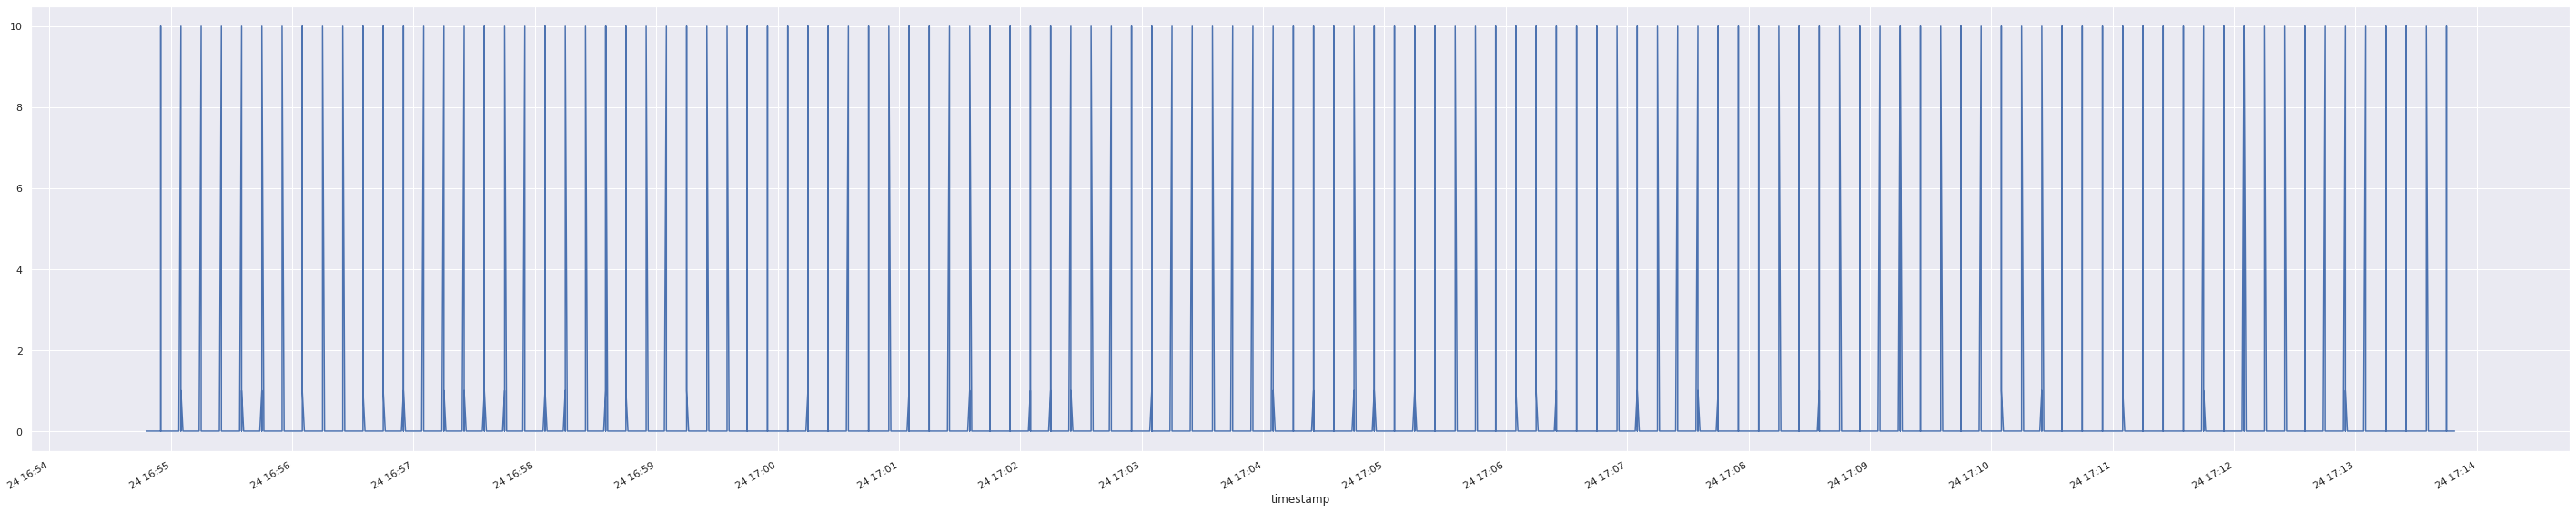

In [ ]:
plot_clicks_displays(base,"ip","238.186.83.58")

In [ ]:
suspect = base[base["ip"] == "238.186.83.58"]
print("Seen per minute : ~", len(suspect)/20, "times")

Seen per minute : ~ 114.0 times


Global trend for IP

---
We use a one minute subset to get the normal display/click count in one minute for each IP.
With the graph analysis, we can deduce that an IP should not click more than 5 times per minute.

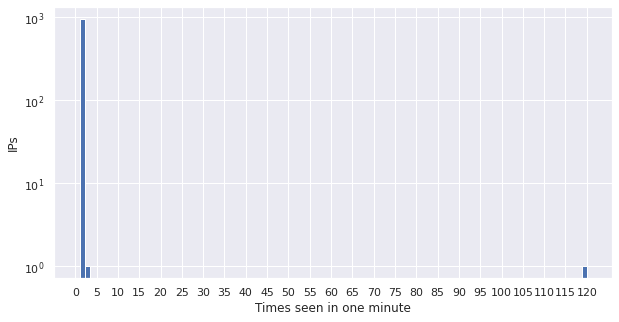

In [ ]:
df = get_one_min_subset(base)
counts = df.groupby("ip").count()["uid"]

plt.figure(figsize=(10,5))
plt.xticks(np.arange(0, counts.max()+1, 5.0))
counts.hist(bins=100)
plt.xlabel("Times seen in one minute")
plt.ylabel("IPs")
plt.yscale("log")
plt.show()

Remove the suspect IP for the next analysis

In [ ]:
base = base[base.ip != "238.186.83.58"]

## UID analysis

Some uid have lots of click/display associated, which is quite suspicious.

In [ ]:
base["uid"].value_counts()

d704f8f3-d2a5-42a6-ae3d-c625a2adaa0d    263
0d7d54f6-ee02-498d-a3d4-bad15d9d2b17    262
28000038-ca40-41e6-a4c2-fcecd1b9fb4d    257
f22c7e37-1312-4e78-a770-9af6467a05fd    253
c762d2d1-5556-448c-9167-7467cc4e0a95    249
                                       ... 
9626a6bb-2dca-4ecf-bf5e-91de05b03610      1
109db97c-a79b-433d-9735-7cc9c50a7ac3      1
d433074c-959c-4354-b396-db33903a2365      1
2a3ec9a5-82e8-4334-a292-73b432075adb      1
311c73d8-58eb-4528-b85f-129f9f4c7d2f      1
Name: uid, Length: 7572, dtype: int64

Analysis of the most seen uid : d704f8f3-d2a5-42a6-ae3d-c625a2adaa0d

---

It's number of clicks and displays seems very suspicious, more than one display/click every 10s.

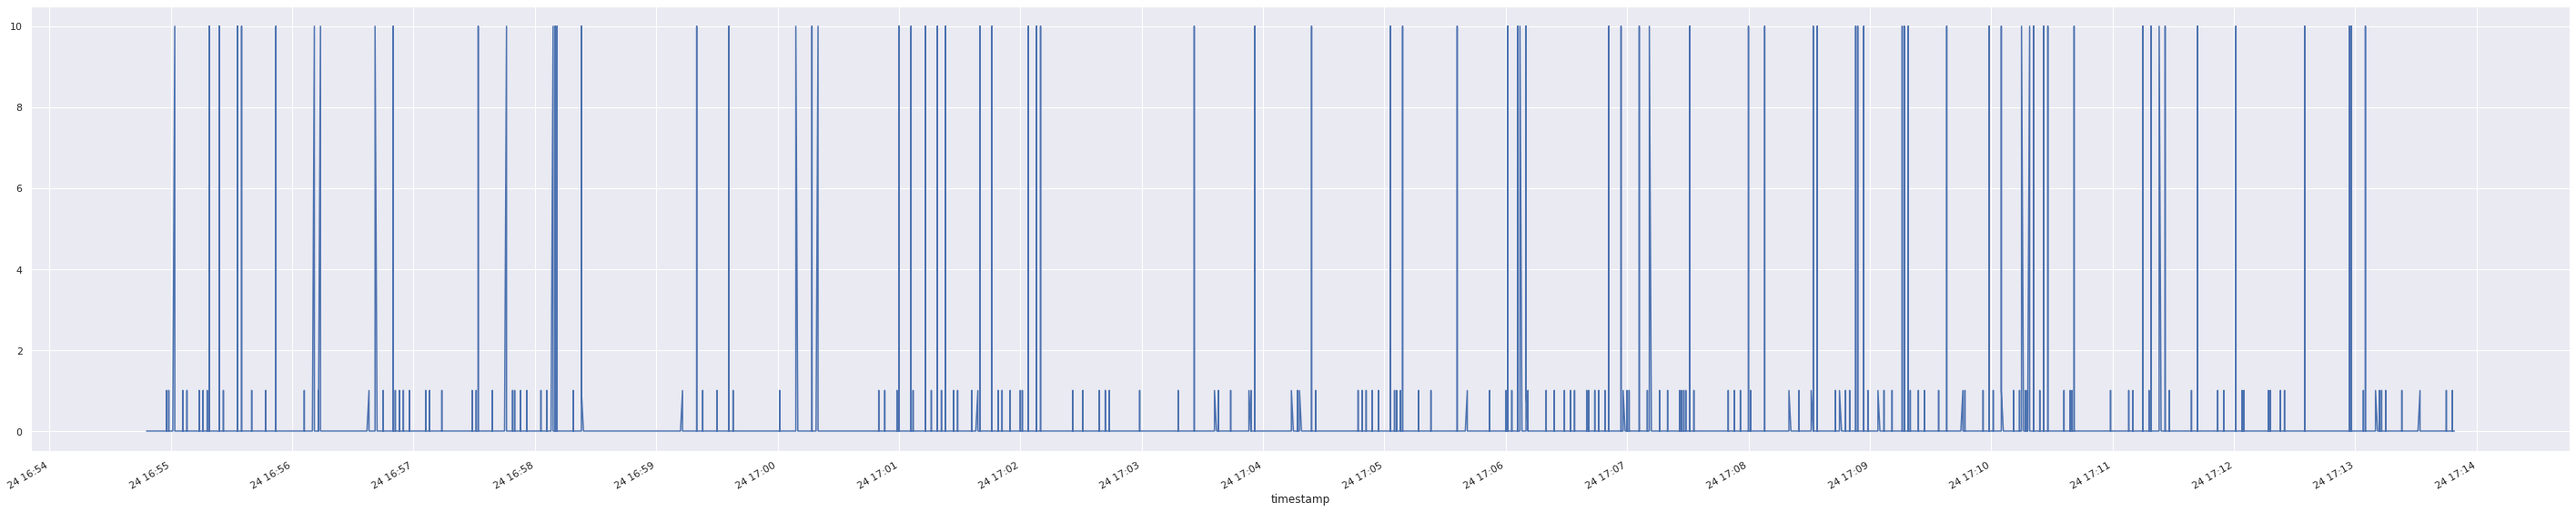

In [ ]:
plot_clicks_displays(base,"uid","d704f8f3-d2a5-42a6-ae3d-c625a2adaa0d")

In [ ]:
suspect = base[base["uid"] == "d704f8f3-d2a5-42a6-ae3d-c625a2adaa0d"]
print("Seen per minute : ~", len(suspect)/20, 'times')

Seen per minute : ~ 13.15 times


Global trend for UID

---
We use a one minute subset to get the normal display/click count in one minute for each UID. With the graph analysis, we can deduce that an UID should not click more than 2 times per minute.

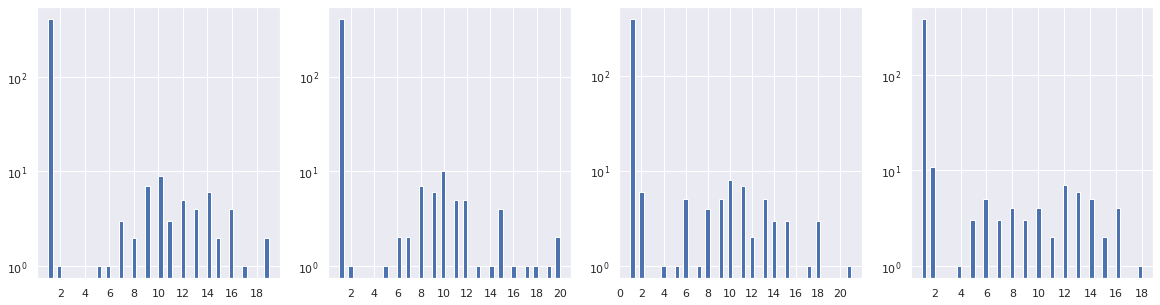

In [ ]:
fig, axes = plt.subplots(1,4)
for axe in axes:
  df = get_one_min_subset(base)
  counts = df.groupby("uid").count()["ip"]  
  axe.axes.set_xticks(np.arange(0, counts.max()+1, 2.0))
  counts.hist(bins=50, ax=axe, figsize=(20,5))
  axe.set_yscale("log")
plt.show()

Outlier check on the full data

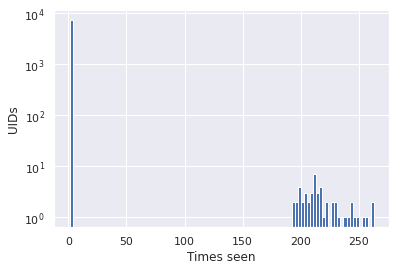

In [ ]:
plt.hist(base["uid"].value_counts(), bins=100)
plt.xlabel("Times seen")
plt.ylabel("UIDs")
plt.yscale('log')
plt.show()

Remove the uids seen more than 100 times

In [ ]:
vc = base["uid"].value_counts()
seen_a_lot= vc.loc[vc>100].index.tolist() #uid seen more than 100 times 
base = base[base["uid"].isin(seen_a_lot)==False]

## ImpressionID analysis

The count of distinct seen impressionId does not raise any suspicion in particular.

In [ ]:
base["impressionId"].value_counts()

e6e06698-df35-4eaa-bc8c-634ea26d5fb8    2
46bfd913-06a3-448b-9d86-4b4113873f7b    2
fd9e3107-e9d6-447a-aadf-bc6c64e01aa0    2
28dc6813-115b-4388-85e2-82a2c10ec828    2
fd8869ec-729c-419d-9424-8c932159ed74    2
                                       ..
833f5353-f02b-424d-8ae6-7e4542fb5451    1
d1c820fb-92c7-415f-8f22-6f1834f26f71    1
36db485c-5a6c-47ff-92f5-ee8c4a11d6e2    1
5296d98c-91c2-4a01-b707-6efb7bc759e8    1
82e5296e-e6f3-427f-85ab-373093be05d1    1
Name: impressionId, Length: 7584, dtype: int64

Analysis of the interval between displays and clicks

---

As we can see bellow, most clicks are made one minute after they were diplayed, but no clear outliers emerge.

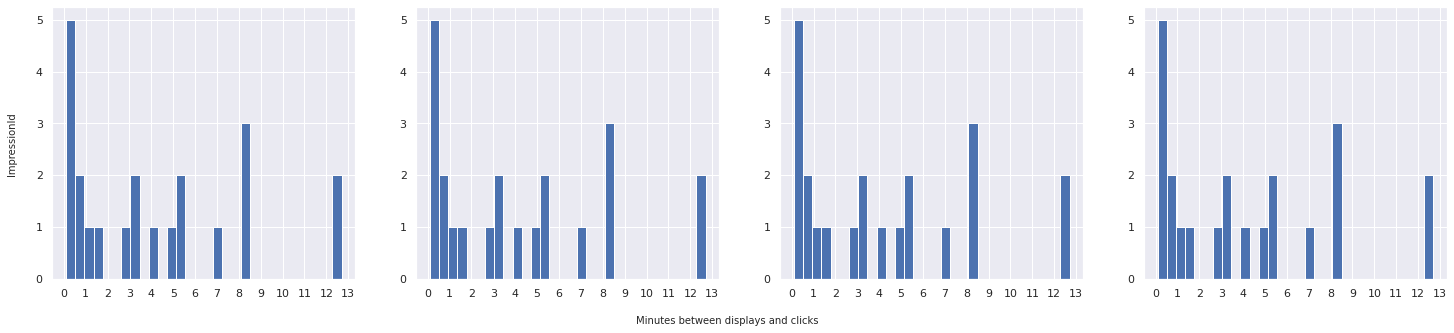

In [ ]:
fig, axes = plt.subplots(1,4)
for axe in axes:
  df = base.sample(frac=0.25,random_state=200)
  vc = df["impressionId"].value_counts()
  seen_twice = vc.loc[vc==2].index.tolist()
  intervals = df.loc[df["impressionId"].isin(seen_twice)].reset_index().groupby("impressionId")['timestamp'].apply(list)
  intervals = intervals.apply(lambda x : (max(x) - min(x)).seconds/60)
  axe.axes.set_xticks(np.arange(0, intervals.max()+1, 1.0))
  intervals.hist(bins=30, ax=axe, figsize=(25,5))

fig.text(0.5, 0, 'Minutes between displays and clicks', ha='center')
fig.text(0.1, 0.5, 'ImpressionId', va='center', rotation='vertical')
plt.show()

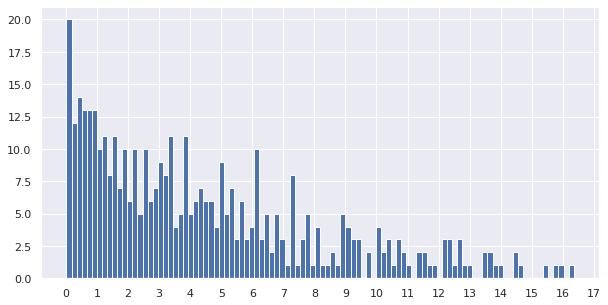

In [ ]:
vc = base["impressionId"].value_counts()
seen_twice = vc.loc[vc==2].index.tolist()
intervals = base.loc[base["impressionId"].isin(seen_twice)].reset_index().groupby("impressionId")['timestamp'].apply(list)
intervals = intervals.apply(lambda x : (max(x) - min(x)).seconds/60)
plt.figure(figsize=(10,5))
intervals.hist(bins=100)
plt.xticks(np.arange(0, intervals.max()+1, 1.0))
plt.show()

Nevertheless, some clicks are made less than one second after they were displayed, which could be viewed as suspect.

In [ ]:
intervals = base.loc[base["impressionId"].isin(seen_twice)].reset_index().groupby("impressionId")['timestamp'].apply(list)
intervals = intervals.apply(lambda x : (max(x) - min(x)).seconds)
intervals.loc[intervals<=1]

impressionId
619fbcf3-a788-48cc-95fa-068dc653ace8    1
7bad428a-6a70-4a92-b294-4f635cd1393d    1
a217ebcb-fc67-42ef-ad1e-64ad4eaaa3a4    1
b2062945-b6b8-4d18-a078-4455f1be72f4    1
Name: timestamp, dtype: int64